<a href="https://colab.research.google.com/github/Uros-Males/Minimization_Problem_On_Identical_Machines_Analysis/blob/main/XONLYCLASS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#IN PROGRESS....
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
import time
import keras

df = pd.read_csv('/content/sample_data/C-instances-runtime-analysis(1) (1).csv')
df2 = df[df['train'] == 1]
print(df2['y'].max())
ymax_train1 = df2['y'].max()
# sve sa train = 0 y = max(y) + 1

#for i in range(df.shape[0]):
#  if(df.iloc[i]['train'] == 0):
#    df.loc[i, 'y'] = ymax_train1 + 1

lower_bound = df['n'] * df['av.length'] / df['m']
lower_bound = lower_bound.astype('int') + 1

upper_bound = np.minimum(df[' LPTUB'], df[' SLACKUB'])
df['rel. bound'] = (upper_bound-lower_bound)/(upper_bound)
df['rel. bound'] = df['rel. bound']*10000

df['category'] = df['y']
for i in range(df.shape[0]):
  #print(df.iloc[i]['y'])
  if(df.iloc[i]['y'] < 1):
    df.loc[i, 'category'] = 0
  elif(df.iloc[i]['y'] >= 1 and df.iloc[i]['y'] < 5):
    df.loc[i, 'category'] = 1
  elif(df.iloc[i]['y'] >= 5 and df.iloc[i]['y'] < 10):
    df.loc[i, 'category'] = 2
  else:
    df.loc[i, 'category'] = 3

print(df['category'].max())
print(df['y'].max())
shuffled = df.sample(frac=1).reset_index()

columns_dont_want = ['y', 'index', 'inst.name','type', 'CPLEXStatus'] 
select = [x for x in shuffled.columns if x not in columns_dont_want]

X = shuffled.loc[:, select]

y = shuffled.loc[:,'y']
names = ['indeks', 'n', 'n/m', '(n/m)^2', '(n/m)^3', 'm/n', 'av.length', 'std.dev', 'median', 'range', 'min', 'max', 'k']




19.907111
3.0
19.907111


In [2]:
y_new = []
for val in y:
  if(val<1):
    y_new.append(0)
  elif(1 <= val and val <5):
    y_new.append(1)
  elif(5<=val and val<10):
    y_new.append(2)
  else:
    y_new.append(3)

shuffled['y_new'] = y_new
y_encoded = shuffled.loc[:,'y_new']
y_new = np.array(y_new)
X_modified = X

In [3]:
from imblearn.over_sampling import RandomOverSampler

names = ['min', 'n/m', 'std.dev','av.length']
X_modified = X.drop([   'train', '(n/m)^2', '(n/m)^3', '(m/n)^2', '(m/n)^3'], axis = 1)
X_modified['n/m'] = X_modified['n/m']
print(X_modified.head())
# n, class, subtype, 'rel. bound','av.length'


from imblearn.over_sampling import RandomOverSampler

category = X_modified['category']
tmp = X_modified.drop(['category'], axis = 1)
tmp['y_enc'] = y_encoded


oversample = RandomOverSampler(random_state=0)
tmp, category = oversample.fit_resample(tmp, category.astype('int'))

tmp = tmp.sample(frac = 1).reset_index()
y_encoded = tmp['y_enc']
X_modified = tmp.drop(['y_enc'], axis = 1)
print(X_modified.shape[0])
print(X_modified.head())

   subtype  class  indeks    n   m  n/m       m/n   av.length     std.dev  \
0       12      2       1  108  12  9.0  0.111111   56.064816   24.096489   
1        3      3       7   20   8  2.5  0.400000   75.650002   16.180803   
2       12      1       6  108  12  9.0  0.111111   48.379631   30.022339   
3        1      6       9  180  90  2.0  0.500000  437.061096  156.065231   
4        9      3      10  198  44  4.5  0.222222   76.323235   14.409405   

   median  range  min  max    k   LPTUB   SLACKUB   rel. bound  category  
0    52.5     80   20  100   58     508       505     0.000000       0.0  
1    74.0     45   53   98   16     216       212  1037.735849       0.0  
2    44.0     98    1   99   66     440       437    22.883295       0.0  
3   450.5    534  181  715  153     900       900   277.777778       0.0  
4    76.0     50   50  100   51     371       361   470.914127       0.0  
29120
   index  subtype  class  indeks    n   m   n/m       m/n   av.length  \
0   9195

In [4]:
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical

l_encode = LabelEncoder()
l_encode.fit(y_encoded)
y_encoded = l_encode.transform(y_encoded)
y_encoded = to_categorical(y_encoded)
y_encoded

array([[0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       ...,
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.]], dtype=float32)

In [5]:
from sklearn import preprocessing

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X_modified, y_encoded, random_state=0, train_size = 0.9)



print(X_train.shape[0])
print(X_test.shape[0])

X_train = sc.fit_transform(X_train)
X_test_copy = X_test
X_test = sc.transform(X_test)


26208
2912


In [6]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

classifier = Sequential()
classifier.add(Dense(16, input_dim = X_modified.shape[1], activation='relu'))

classifier.add(Dropout(0.2))

classifier.add(Dense(4, activation = 'softmax'))
classifier.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                304       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 4)                 68        
                                                                 
Total params: 372
Trainable params: 372
Non-trainable params: 0
_________________________________________________________________


In [7]:
from keras.metrics import accuracy
from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 25, 
                                        restore_best_weights = True)
  
history = classifier.fit(X_train, y_train, batch_size = 128, 
                    epochs = 200, shuffle = True)


Epoch 1/200
205/205 [==============================] - 1s 2ms/step - loss: 0.8605 - accuracy: 0.6350
Epoch 2/200
205/205 [==============================] - 0s 2ms/step - loss: 0.6133 - accuracy: 0.7466
Epoch 3/200
205/205 [==============================] - 0s 2ms/step - loss: 0.5073 - accuracy: 0.8027
Epoch 4/200
205/205 [==============================] - 0s 2ms/step - loss: 0.4384 - accuracy: 0.8350
Epoch 5/200
205/205 [==============================] - 0s 2ms/step - loss: 0.3917 - accuracy: 0.8605
Epoch 6/200
205/205 [==============================] - 0s 2ms/step - loss: 0.3525 - accuracy: 0.8763
Epoch 7/200
205/205 [==============================] - 0s 2ms/step - loss: 0.3251 - accuracy: 0.8899
Epoch 8/200
205/205 [==============================] - 0s 2ms/step - loss: 0.3046 - accuracy: 0.8976
Epoch 9/200
205/205 [==============================] - 1s 4ms/step - loss: 0.2854 - accuracy: 0.9044
Epoch 10/200
205/205 [==============================] - 0s 2ms/step - loss: 0.2703 - accura

accuracy: 96.15%


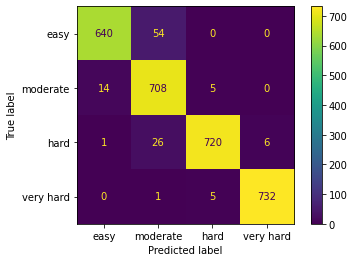

In [8]:
from keras.metrics import accuracy
pred = classifier.predict(X_test)
pred_ = np.argmax(pred, axis = 1)
pred_ = l_encode.inverse_transform(pred_)

true_y = l_encode.inverse_transform(np.argmax(to_categorical(y_test), axis = 1)[:,1])
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(true_y, pred_, labels=[0, 1, 2, 3])
cmd = ConfusionMatrixDisplay(cm, display_labels=['easy','moderate', 'hard', 'very hard'])

cmd.plot()

cnt = 0
cnt_correct = 0
for i in range(len(pred)):
  cnt += 1
  if(pred_[i] == true_y[i]):
    cnt_correct += 1
print(f'accuracy: {(cnt_correct/cnt)*100:.2f}%')


ROC AUC score: 0.9741093959350041


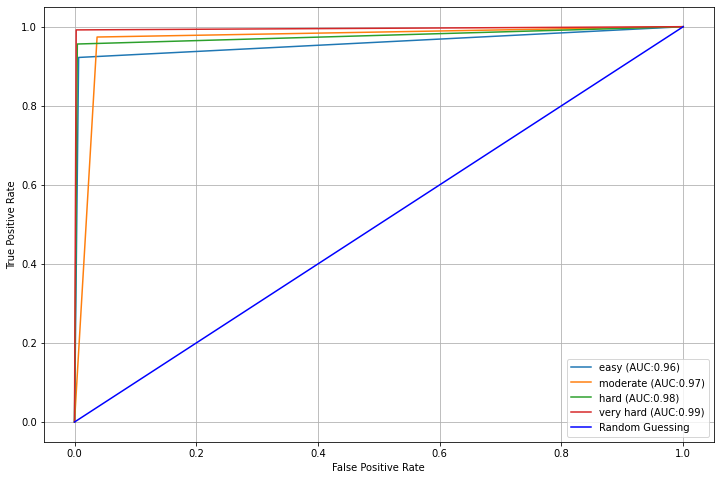

In [9]:
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score


target= ['easy', 'moderate', 'hard', 'very hard']

fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)


print('ROC AUC score:', multiclass_roc_auc_score(true_y, pred_))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.grid()
plt.show()